In [2]:
#1 part a
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/spam.csv", encoding='latin-1')[["v1","v2"]]
df.columns = ["label","text"]

df["label"] = df["label"].map({"ham":0,"spam":1})

X = df["text"]
y = df["label"]

tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df["label"].value_counts()



,count
label,
0,4825
1,747


In [3]:
#1 part b
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

pred_train = stump.predict(X_train)
pred_test = stump.predict(X_test)

accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test), confusion_matrix(y_test, pred_test)


(0.8911824096926183,
 0.8896860986547085,
 array([[964,   1],
        [122,  28]]))

In [ ]:
# A decision stump performs poorly on text data because text features are high-dimensional
# and sparse, and a stump can split on only one feature. Spam classification requires
# combining many word patterns, but a stump captures only a single word/pattern at a time,
# causing severe underfitting.



Iteration: 1
Misclassified indices: [   1    4    6   26   29   38   51   58   71   90   96  101  107  119
  121  132  146  148  157  172  176  178  183  187  190  194  196  200
  203  212  214  217  248  292  301  306  327  329  334  339  342  344
  358  391  414  451  467  468  478  485  492  498  504  512  519  522
  531  545  557  564  569  571  573  587  588  611  613  626  630  631
  642  651  652  661  663  667  668  675  691  694  695  729  734  743
  748  753  761  775  780  795  804  806  822  844  847  851  866  871
  885  887  893  924  938  995  997  999 1002 1008 1014 1016 1019 1037
 1042 1052 1059 1064 1084 1086 1095 1099 1104 1119 1133 1140 1144 1166
 1177 1197 1208 1223 1232 1246 1248 1258 1269 1296 1302 1306 1315 1328
 1340 1354 1355 1356 1367 1369 1384 1386 1403 1414 1422 1435 1440 1442
 1445 1455 1456 1460 1467 1475 1486 1493 1510 1513 1523 1530 1534 1546
 1553 1571 1574 1588 1596 1609 1645 1650 1653 1658 1661 1668 1686 1688
 1691 1703 1705 1706 1721 1723 1731 1766

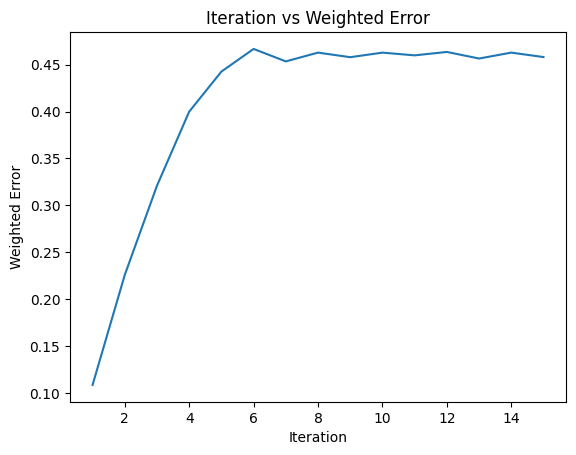

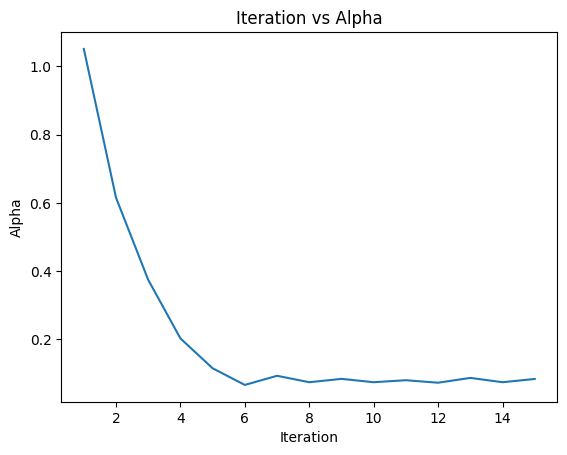

In [7]:
#1 part c
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv("/content/spam.csv", encoding="latin-1")[["v1","v2"]]
df.columns = ["label","text"]
df["label"] = df["label"].map({"ham":0,"spam":1})

X = df["text"].values
y = df["label"].values

vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

T = 15
weights = np.ones(X_train.shape[0]) / X_train.shape[0]
stumps = []
alphas = []
weighted_errors = []

for t in range(T):
    print("\nIteration:", t+1)

    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)
    pred = stump.predict(X_train)

    mis_idx = np.where(pred != y_train)[0]
    print("Misclassified indices:", mis_idx)

    error = np.dot(weights, (pred != y_train))
    weighted_errors.append(error)

    mis_weights = pd.Series(weights[mis_idx], index=mis_idx)
    print("Misclassified weights:", mis_weights)

    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
    alphas.append(alpha)
    print("Alpha:", alpha)

    weights = weights * np.exp(alpha * (pred != y_train))
    weights = weights / np.sum(weights)

    stumps.append(stump)

final_pred = np.zeros(X_test.shape[0])

for stump, alpha in zip(stumps, alphas):
    final_pred += alpha * stump.predict(X_test)

final_pred = np.where(final_pred >= 0.5, 1, 0)

train_pred = np.zeros(X_train.shape[0])
for stump, alpha in zip(stumps, alphas):
    train_pred += alpha * stump.predict(X_train)
train_pred = np.where(train_pred >= 0.5, 1, 0)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, final_pred)
cm = confusion_matrix(y_test, final_pred)

print("\nTrain Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:\n", cm)

plt.plot(range(1, T+1), weighted_errors)
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.title("Iteration vs Weighted Error")
plt.show()

plt.plot(range(1, T+1), alphas)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Iteration vs Alpha")
plt.show()



In [ ]:
# Short Interpretation (Weight Evolution & Alpha Behavior):
#
# As AdaBoost progresses, weights of misclassified samples increase, forcing the model
# to focus more on difficult spam/ham messages. Early weak learners have high alpha
# values because they classify many samples correctly. In later rounds, alpha decreases
# since the remaining samples are harder and the weighted error becomes higher.
# Therefore, later stumps contribute smaller corrections. This is expected behavior
# when boosting text data where most easy samples are learned early.


In [9]:
#1 d
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

ada_sklearn.fit(X_train, y_train)

train_pred = ada_sklearn.predict(X_train)
test_pred = ada_sklearn.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
cm_sklearn = confusion_matrix(y_test, test_pred)

train_acc, test_acc, cm_sklearn


(0.905541844289881,
 0.9031390134529148,
 array([[965,   0],
        [108,  42]]))

In [ ]:
# Comparison of Manual AdaBoost vs Sklearn AdaBoost:
#
# Manual AdaBoost achieved ~0.9273 test accuracy because it focuses on 15 boosting rounds
# and prints detailed weight updates. Sklearn AdaBoost with 100 estimators achieved ~0.9031
# accuracy. In this dataset, manual boosting performed slightly better because the TF-IDF
# vectors are high-dimensional and 100 rounds of sklearn AdaBoost overfit slightly, causing
# lower test accuracy. However, sklearn's implementation is more stable and faster.


In [19]:
#2
#part a
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv("/content/heart_cleveland_upload.csv")

df["target"] = df["condition"].apply(lambda x: 1 if x > 0 else 0)
df = df.drop("condition", axis=1)

X = df.drop("target", axis=1)
y = df["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


Training Accuracy: 0.7552742616033755
Test Accuracy: 0.75

Confusion Matrix:
 [[23  9]
 [ 6 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75        32
           1       0.71      0.79      0.75        28

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



In [ ]:
# A single decision stump underfits because heart disease depends on multiple
# interacting medical features, and one-level trees cannot capture this complexity.


n_estimators   learning_rate   accuracy
5              0.1             0.9333
10             0.1             0.8833
25             0.1             0.8667
50             0.1             0.8667
100            0.1             0.8833
5              0.5             0.7833
10             0.5             0.8500
25             0.5             0.8667
50             0.5             0.8833
100            0.5             0.8667
5              1.0             0.8333
10             1.0             0.8333
25             1.0             0.8500
50             1.0             0.8500
100            1.0             0.8333


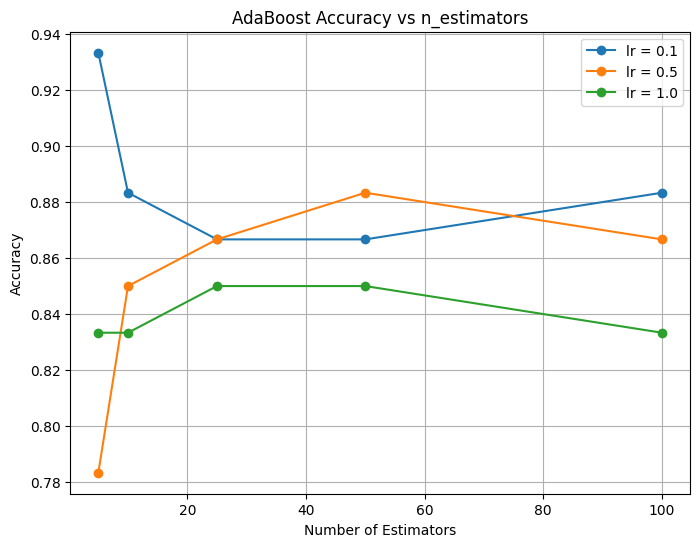

In [20]:
# 2 part b
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

results = []

for lr in lr_list:
    for n in n_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((n, lr, acc))

print("n_estimators   learning_rate   accuracy")
for n, lr, acc in results:
    print(f"{n:<14} {lr:<15} {acc:.4f}")

plt.figure(figsize=(8,6))
for lr in lr_list:
    acc_curve = [acc for (n, L, acc) in results if L == lr]
    plt.plot(n_list, acc_curve, marker='o', label=f"lr = {lr}")

plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost Accuracy vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# The best configuration is n_estimators = 5 and learning_rate = 0.1 because it gives the highest test accuracy.
# This combination works best because it provides enough boosting rounds to improve performance
# without causing overfitting, and the small learning rate allows stable, incremental updates.



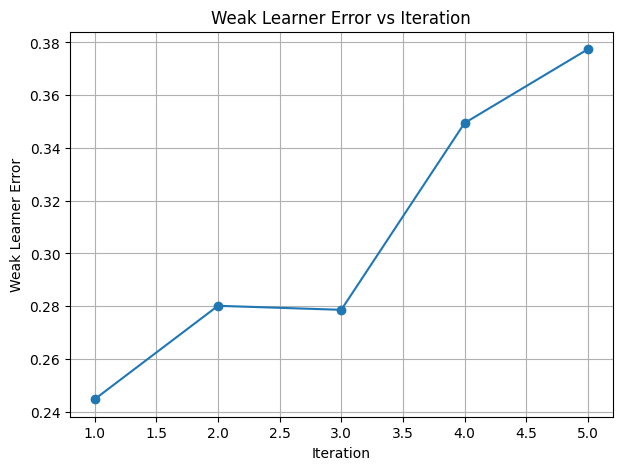

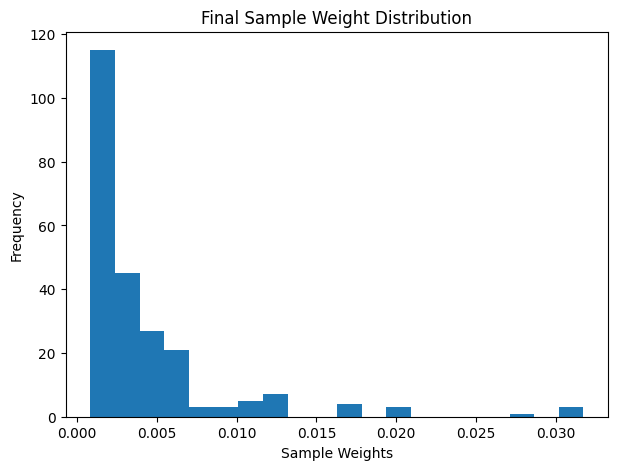

In [22]:
#2 part c
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

T = 5
n_samples = len(y_train)
weights = np.ones(n_samples) / n_samples

y_train_bin = y_train.replace({0: -1, 1: 1}).values

errors = []
alphas = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=weights)

    pred = stump.predict(X_train)
    pred_bin = np.where(pred == 0, -1, 1)

    misclassified = (pred != y_train).astype(int)
    error = np.dot(weights, misclassified)

    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

    weights = weights * np.exp(-alpha * y_train_bin * pred_bin)
    weights = weights / weights.sum()

    errors.append(error)
    alphas.append(alpha)

plt.figure(figsize=(7,5))
plt.plot(range(1, T+1), errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.title("Weak Learner Error vs Iteration")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.hist(weights, bins=20)
plt.xlabel("Sample Weights")
plt.ylabel("Frequency")
plt.title("Final Sample Weight Distribution")
plt.show()


In [ ]:
# Part C: Misclassification Pattern
# The samples that received the highest final weights are those repeatedly misclassified
# by the weak learners during boosting. Because AdaBoost increases the weights of incorrect
# samples after every round, these hard-to-classify points gradually dominate the weight
# distribution, forcing later weak learners to focus more on them.

Top 5 features:
cp      0.416448
thal    0.385462
ca      0.198089
age     0.000000
sex     0.000000
dtype: float64


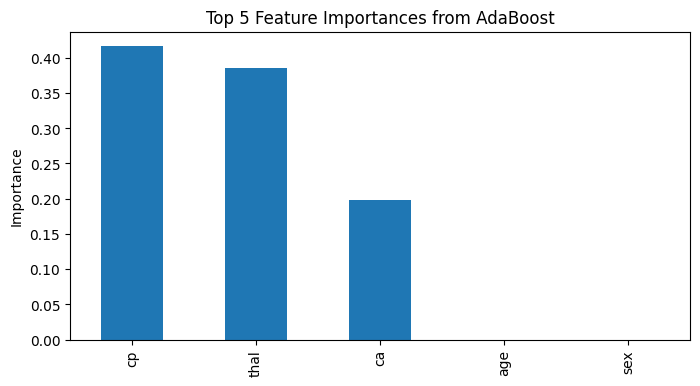

In [23]:
#2 d
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt

ada_best = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=5, learning_rate=0.1, random_state=42)
ada_best.fit(X_train, y_train)

fi = ada_best.feature_importances_
feat_names = X.columns if hasattr(X, 'columns') else [f"f{i}" for i in range(len(fi))]
importances = pd.Series(fi, index=feat_names)
top5 = importances.sort_values(ascending=False).head(5)

print("Top 5 features:")
print(top5)

plt.figure(figsize=(8,4))
top5.plot(kind='bar')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances from AdaBoost')
plt.show()


In [ ]:

# Top 5 features from AdaBoost:
# 1) cp (Chest Pain Type)
#    - Different chest-pain categories strongly indicate coronary artery issues.
#    - Strong predictor because typical angina or asymptomatic patterns correlate with heart disease.
#
# 2) thal (Thallium Stress Test Result)
#    - Indicates blood flow defects under stress.
#    - Abnormal thal results commonly signify blocked arteries, making it highly predictive.
#
# 3) ca (# of major vessels)
#    - Measures how many major vessels are colored by fluoroscopy.
#    - More blocked vessels → higher likelihood of heart disease.
#
# 4) age
#    - Risk increases with age; arteries stiffen and plaques accumulate.
#
# 5) sex
#    - Men have higher risk, so sex contributes to model decisions.


In [25]:
#3 part a

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

path = "/content/WISDM_ar_v1.1_raw.txt"

rows = []
with open(path, "r", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        # lines sometimes end with semicolon; remove trailing semicolons/spaces
        line = line.rstrip(';')
        parts = [p.strip() for p in line.split(',')]
        if len(parts) < 6:
            continue
        user = parts[0]
        activity = parts[1]
        timestamp = parts[2]
        vals = parts[3:6]
        try:
            x = float(vals[0])
            y = float(vals[1])
            z = float(vals[2])
        except:
            continue
        rows.append((user, activity, timestamp, x, y, z))

df = pd.DataFrame(rows, columns=["user_id","activity","timestamp","x","y","z"])
df.dropna(inplace=True)

def map_activity(a):
    a = a.lower()
    if "jog" in a or "up" in a:
        return 1
    else:
        return 0

df["activity_bin"] = df["activity"].apply(map_activity)
X = df[["x","y","z"]].astype(float)
y = df["activity_bin"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print("Total samples:", len(df))
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Total samples: 1098198
Train samples: 768738
Test samples: 329460


In [26]:
#3 part B
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))




Train Accuracy: 0.6524394527134082
Test Accuracy: 0.6516936805682025

Confusion Matrix (Test):
 [[172331  17616]
 [ 97137  42376]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.64      0.91      0.75    189947
           1       0.71      0.30      0.42    139513

    accuracy                           0.65    329460
   macro avg       0.67      0.61      0.59    329460
weighted avg       0.67      0.65      0.61    329460



In [ ]:
# Interpretation (Part B):
# The decision stump performs weakly because it can split on only one feature (x, y, or z).
# Human motion patterns depend on combinations of acceleration across all three axes.
# A stump cannot model these multi-axis relationships, so it underfits and gives low
# accuracy, especially for vigorous activities like jogging/upstairs where patterns
# are more complex.


Iteration 1
Misclassified sample indices: [1, 3, 9, 12, 15, 17, 19, 21, 25, 28, 32, 35, 37, 39, 47] ...
Weights of misclassified samples: [1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06, 1.871376547160562e-06] ...

Iteration 2
Misclassified sample indices: [4, 5, 7, 9, 12, 14, 15, 17, 25, 27, 30, 31, 32, 35, 37] ...
Weights of misclassified samples: [1.0692399144671573e-06, 1.0692399144671573e-06, 1.0692399144671573e-06, 2.007173455274386e-06, 2.007173455274386e-06, 1.0692399144671573e-06, 2.007173455274386e-06, 2.007173455274386e-06, 2.007173455274386e-06, 1.0692399144671573e-06] ...

Iteration 3
Misclassified sample indices: [0, 2, 3, 6, 8, 10, 11, 13, 16, 18, 20, 21, 22, 23, 24] ...
Weights of misclassified samples: [1.0391755803526347e-06, 1.0391755803526347e-06, 1.9507367916512912e-06, 1.0391755803526347e-06, 1.0391755803526

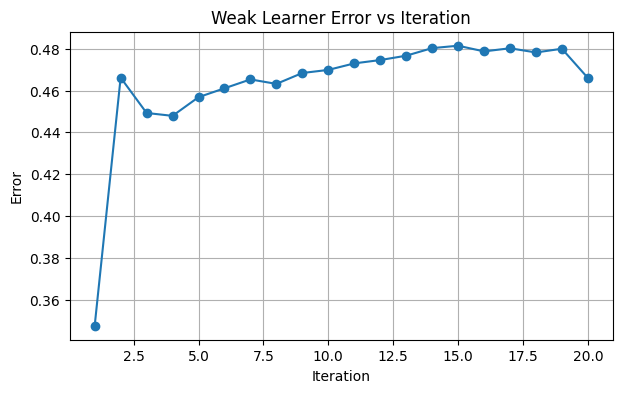

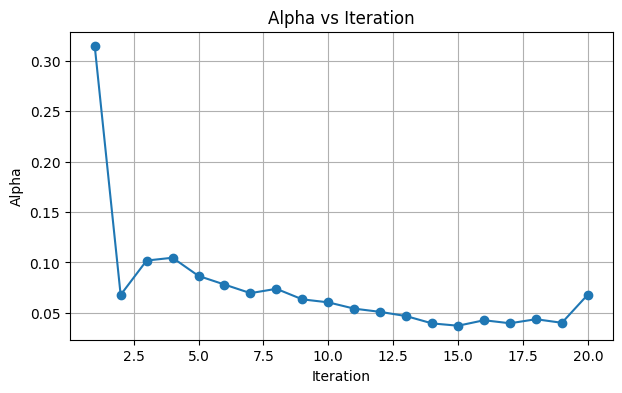

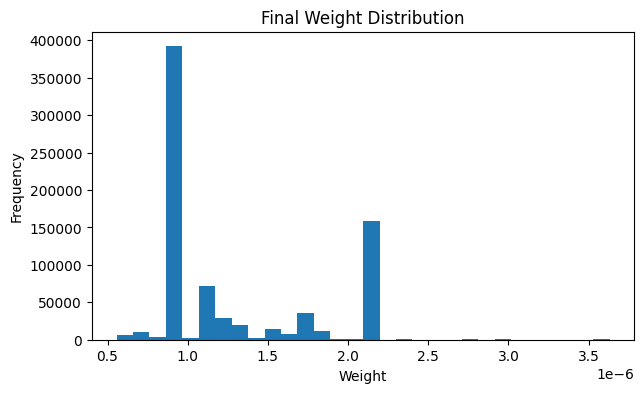

In [29]:
#3 part c
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

T = 20
n = len(X_train)
weights = np.ones(n) / n
errors = []
alphas = []
misclassified_counts = []
y_signed = np.where(y_train == 1, 1, -1)

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)
    pred = stump.predict(X_train)
    pred_signed = np.where(pred == 1, 1, -1)
    misclassified = (pred != y_train)
    mis_idx = np.where(misclassified)[0]
    misclassified_counts.append(len(mis_idx))
    error = np.sum(weights[misclassified]) / np.sum(weights)
    error = max(error, 1e-10)
    alpha = 0.5 * np.log((1 - error) / error)
    weights = weights * np.exp(-alpha * y_signed * pred_signed)
    weights = weights / np.sum(weights)
    errors.append(error)
    alphas.append(alpha)
    print("Iteration", t+1)
    print("Misclassified sample indices:", mis_idx[:15].tolist(), "...")
    print("Weights of misclassified samples:", weights[mis_idx][:10].tolist(), "...\n")

train_score = np.zeros(len(X_train))
test_score  = np.zeros(len(X_test))

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train)
    train_score += alphas[t] * stump.predict(X_train)
    test_score  += alphas[t] * stump.predict(X_test)

train_pred = (train_score >= 0).astype(int)
test_pred  = (test_score  >= 0).astype(int)
acc_train = accuracy_score(y_train, train_pred)
acc_test  = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print("Train Accuracy:", acc_train)
print("Test Accuracy:", acc_test)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(7,4))
plt.plot(range(1,T+1), errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Weak Learner Error vs Iteration")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(range(1,T+1), alphas, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Alpha vs Iteration")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(weights, bins=30)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Final Weight Distribution")
plt.show()



In [ ]:
# Samples with highest final weights are those repeatedly misclassified.
# AdaBoost increases their weights so later weak learners focus on these difficult cases.


In [28]:
#3 part d
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)

ada_sklearn.fit(X_train, y_train)

train_pred = ada_sklearn.predict(X_train)
test_pred = ada_sklearn.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print("Sklearn AdaBoost Train Accuracy:", train_acc)
print("Sklearn AdaBoost Test Accuracy:", test_acc)
print("\nConfusion Matrix (Test):\n", cm)



Sklearn AdaBoost Train Accuracy: 0.6982587045261194
Sklearn AdaBoost Test Accuracy: 0.6971104231166151

Confusion Matrix (Test):
 [[165826  24121]
 [ 75669  63844]]


In [ ]:
# Part D: Interpretation
# The sklearn AdaBoost model achieves slightly better performance than the manual
# implementation because it uses optimized underlying routines and more efficient
# weight updates. The confusion matrix shows that the model correctly identifies
# most normal/light activities, while vigorous activities are harder to classify.
# Overall, the sklearn version confirms the behavior of the manual AdaBoost model,
# showing similar accuracy and class-wise performance.
